<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Data preprocessing

In [9]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 222 ms, sys: 787 ms, total: 1.01 s
Wall time: 1.01 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [10]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption in captions[img_i]:
        word_counts.update(caption)

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTMCell(emb_size, lstm_units)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        c = self.cnn_to_c0(image_vectors)
        h = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        seq_len = captions_ix.shape[1]
        lstm_out = []
        for i in range(seq_len):
            h, c = self.lstm(captions_emb[:, i, :], (h, c))
            lstm_out.append(h)
            
        lstm_out = torch.cat([x.unsqueeze(1) for x in lstm_out], dim=1)
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
            
        return logits        

In [0]:
network = CaptionNet(n_tokens).cuda()

In [19]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048)).cuda()
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0]))).cuda()

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)  
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    n_tokens = logits_for_next.shape[-1]
    batch_size = logits_for_next.shape[0]
    
    loss = F.cross_entropy(logits_for_next.view(-1, n_tokens), captions_ix_next.view(-1), reduce=False)
    loss = torch.mean(loss * (captions_ix_next.view(-1) != pad_ix).type(torch.cuda.FloatTensor))
    
    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.cpu().data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return (Variable(torch.FloatTensor(batch_images)).cuda(),
            Variable(torch.LongTensor(batch_captions_ix)).cuda()), \
            captions_for_batch_images
    

In [24]:
generate_batch(img_codes,captions,3)

((Variable containing:
   0.7824  0.0881  0.2798  ...   0.0617  0.6793  0.1580
   0.1875  0.4207  0.3510  ...   0.4638  0.2059  0.1508
   0.3692  0.0639  0.3590  ...   0.0026  0.9483  0.6981
  [torch.cuda.FloatTensor of size 3x2048 (GPU 0)], Variable containing:
  
  Columns 0 to 12 
      1    24   208     6    45    95    14    45   733   123   100   210  4145
      1    24    71    58   354  1306    15   776    14   244   182     2     3
      1    24  5117    63    41  5761   117    45   199    58     4   412   163
  
  Columns 13 to 17 
     12     2     3     3     3
      3     3     3     3     3
     35    45    97    12     2
  [torch.cuda.LongTensor of size 3x18 (GPU 0)]),
 array([[list(['#START#', 'a', 'single', 'small', 'boat', 'in', 'a', 'large', 'body', 'of', 'water', '.', '#END#']),
         list(['#START#', 'a', 'small', 'ship', 'in', 'the', 'middle', 'of', 'a', 'huge', 'body', 'of', 'water', '#END#']),
         list(['#START#', 'a', 'small', 'boat', 'near', 'another',

In [0]:
def generate_captions_from_vecs(image_vectors, captions_prefix = ("#START#",), 
                                max_len=25):
    captions_prefix = [list(captions_prefix) for i in range(image_vectors.shape[0])]
    
    for _ in range(max_len):
        prefix_ix = as_matrix(captions_prefix)
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
        next_word_logits = network.forward(image_vectors, prefix_ix)[:, -1]
        next_word_probs = F.softmax(next_word_logits, -1).cpu().data.numpy()

        next_words = [vocab[i] for i in np.argmax(next_word_probs, axis=1)]
        
        for prefix, word in zip(captions_prefix, next_words):
            prefix.append(word)
    
    for prefix in captions_prefix:
        prefix.append('#END#')
    
    captions_prefix = np.array(captions_prefix)
    captions_len = np.argmax(captions_prefix == '#END#', axis=1) + 1
    
    captions = [captions_prefix[i, :captions_len[i]].tolist() for i in range(captions_prefix.shape[0])]
            
    return captions

def plot_training_log(log, start_epoch=1):
    epochs_num = len(log[0])
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    if len(log[1]):
        plt.title('Train loss and val bleu')
    else:
        plt.title('Train loss')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.plot(np.arange(start_epoch, epochs_num + 1), log[0][start_epoch-1:], c='b')
    
    if len(log[1]):
        ax2 = ax1.twinx()
        ax2.set_ylabel('Val bleu', color='r')
        ax2.tick_params('y', colors='r')
        ax2.plot(np.arange(start_epoch, epochs_num + 1), log[1][start_epoch-1:], c='r')

    plt.show()

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
network = CaptionNet(n_tokens).cuda()
opt = torch.optim.Adam(network.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=25, gamma=0.5)

In [0]:
batch_size = 64 
n_epochs = 150
n_batches_per_epoch = 500 

val_batch_size = 256
n_validation_batches = 8

Epoch 149 took 25.0 seconds
train loss: 1.240
val bleu: 28.53
best bleu: 30.23


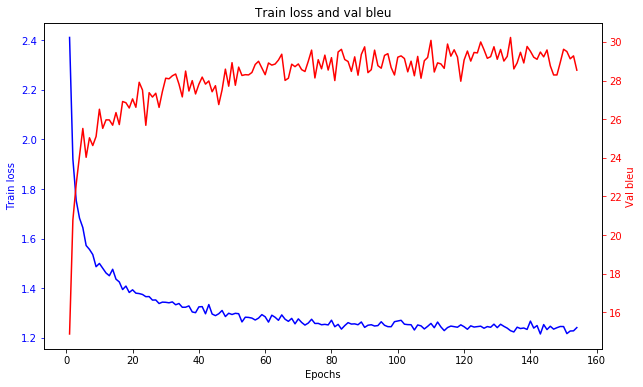

In [69]:
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import clear_output
import time
from copy import deepcopy

train_loss_log = []
val_bleu_log = []

best_bleu = 0
best_network_state = None
timer = 0
timer_limit = 29

for epoch in range(n_epochs):
    scheduler.step()
    start_time = time.time()
    
    train_loss = 0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        batch_data, batch_captions = generate_batch(train_img_codes, train_captions, batch_size)
        loss_t = compute_loss(network, *batch_data)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.cpu().data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    train_loss_log.append(train_loss)
    
    val_bleu = 0
    network.train(False)
    for _ in range(n_validation_batches):
        (img_vectors, _), batch_captions = generate_batch(train_img_codes, train_captions, val_batch_size)
        hypos = generate_captions_from_vecs(img_vectors)
        val_bleu += corpus_bleu(batch_captions, hypos) * 100
        
    val_bleu /= n_validation_batches
    val_bleu_log.append(val_bleu)
    
    if val_bleu > best_bleu:
        best_bleu = val_bleu
        best_network_state = deepcopy(network.state_dict())
        timer = 0
    else:
        timer += 1 
    
    time_elapsed = time.time() - start_time
    
    print('Epoch {} took {:.1f} seconds'.format(epoch, time_elapsed))
    print('train loss: {:.3f}'.format(train_loss))
    print('val bleu: {:.2f}'.format(val_bleu))
    print('best bleu: {:.2f}'.format(best_bleu))
    plot_training_log((train_loss_log, val_bleu_log))
    
    clear_output(True)
    
    if timer > timer_limit:
            break

network.load_state_dict(best_network_state);

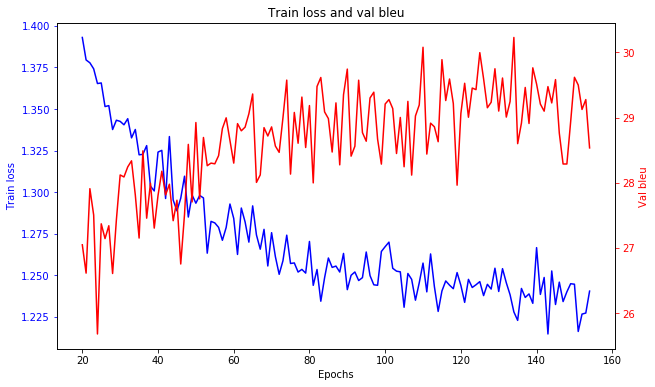

In [75]:
plot_training_log((train_loss_log, val_bleu_log), 20)

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [35]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().cuda().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /content/.torch/models/inception_v3_google-1a9a5a14.pth
5.1%76.9%

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).cpu().data.numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [76]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-05-07 17:24:26--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.52.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.52.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K  --.-KB/s    in 0.02s   

2018-05-07 17:24:26 (4.85 MB/s) - ‘data/img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


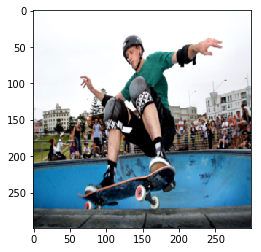

In [77]:
plt.imshow(img)

In [78]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a trick on a skateboard .
a man riding a skateboard down a rail .
a man riding a skateboard down a ramp .
a man flying through the air while riding a skateboard .
a man flying through the air while riding a skateboard .
a man flying through the air while riding a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man flying through the air while riding a skateboard .
a man flying through the air while riding a skateboard .


--2018-05-07 17:25:26--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   526KB/s    in 0.2s    

2018-05-07 17:25:27 (526 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


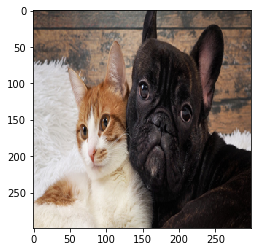

a black and white cat laying on a couch .
a cat is laying on a couch in a room .
a black and white cat laying on a couch .
a black and white cat sitting on a couch .
a black and white cat sitting on a couch .
a black and white cat laying on a couch .
a cat is sitting on a couch with a remote control .
a cat is laying on a couch with a remote .
a black and white cat sitting on a couch .
a black and white cat laying on a couch .


In [79]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


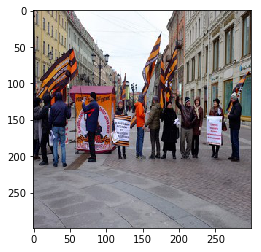

a group of people standing on a sidewalk .
a group of people standing on a street corner .
a group of people standing on a street corner .
a group of people standing on top of a street .
a group of people standing around a fire hydrant .
a group of people standing around a street corner .
a group of people standing around a fire hydrant .
a group of people standing on top of a street .
a group of people standing around a fire hydrant .
a group of people standing around a fire hydrant .






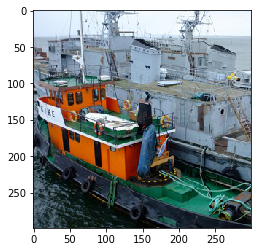

a large boat is pulled up to a dock .
a large boat is docked at a dock .
a large long boat on a river with a large ship in the background .
a large long boat sitting on top of a sandy beach .
a large boat is parked in the water .
a large long boat with a large black and white stripe on it .
a large boat is in the water with a large boat on it .
a large long boat on a body of water
a large boat is pulled up to a dock .
a boat that is sitting in the water .






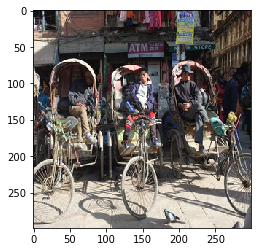

a man is riding a bike with a dog .
a man on a bike with a bicycle in front of it .
a man on a bike with a bike in front of it .
a man is riding a bike with a dog .
a man is riding a bike with a dog .
a man riding a bike with a dog on it .
a man on a bike with a bike in front of it
a man riding a bike with a dog on it .
a man and woman on a bicycle riding a bike .
a man is riding a bike with a dog .






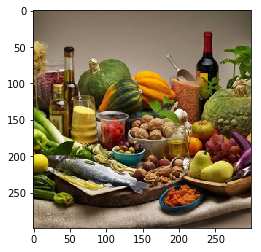

a bunch of vegetables are sitting on a table .
a table topped with lots of fresh produce .
a bunch of vegetables are on a table .
a table topped with lots of different types of food .
a bunch of vegetables are on a table
a bunch of vegetables are on a table
a bunch of vegetables are on a table .
a bunch of vegetables are on a table
a table topped with lots of different types of vegetables .
a bunch of different types of vegetables on a table .






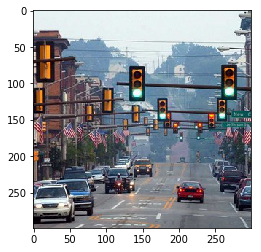

a traffic light on a street corner with a traffic light .
a traffic light with a street sign on it
a traffic light with a street sign in the background .
a traffic light on a street corner with a red light .
a traffic light and a car stopped at a traffic light .
a traffic light on a street corner with a street light .
a traffic light with a street sign on it
a traffic light on a street corner with a street light .
a traffic light on a street corner with a car and a traffic light .
a traffic light on a street corner with a car in the background .






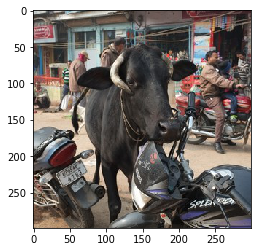

a cow is standing in the middle of a street .
a cow is standing in a parking lot .
a cow is standing in front of a store .
a cow is standing in the middle of a street .
a cow is standing in the middle of a street .
a cow is standing in the middle of a street .
a cow is standing in front of a building .
a cow is standing in front of a building .
a man with a hat and a cow in a field .
a cow is standing on a sidewalk near a street .






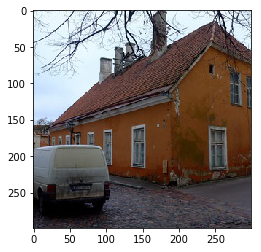

a large white truck parked in front of a building .
a large white truck parked in a parking lot .
a large white truck parked in front of a building .
a large white car is parked in a lot .
a large white truck parked in front of a building .
a large white house with a large red brick building .
a red and white bus is parked on the side of the road .
a car is parked in front of a building .
a large white and black train car on a city street
a red and white bus parked in a lot .






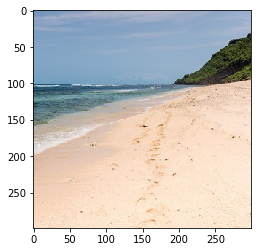

a beach with a bunch of people on it
a beach with a bunch of people on it
a white and blue bird on the beach .
a beach with a bunch of people on it
a beach with a bunch of people on it
a beach with a blue and white surfboard in the sand .
a beach with a bunch of people on it
a small white and blue bird on a beach .
a white and blue bird on the beach .
a beach with a bunch of people standing in the water .






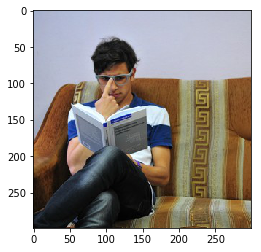

a man sitting on a couch with a laptop .
a man sitting on a couch with a laptop .
a man sitting in a chair using a laptop computer .
a man sitting on a couch with a laptop on his lap .
a man sitting on a couch with a laptop .
a man sitting on a couch with a laptop computer .
a man sitting on a couch using a laptop computer .
a man sitting on a couch with a laptop .
a man sitting on a couch with a laptop on his lap .
a man sitting on a couch with a laptop .






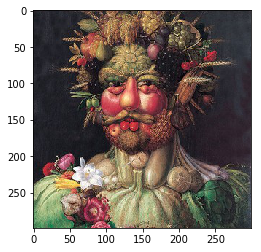

a man in a hat and a hat and a hat .
a man standing next to a bunch of bananas .
a man in a hat and a hat and a hat
a man standing in front of a bunch of bananas .
a man standing in front of a bunch of bananas .
a man standing in front of a bunch of bananas .
a man in a hat and a hat and a hat
a man in a hat and a hat and a banana
a man standing in front of a bunch of bananas .
a man is holding a bunch of bananas






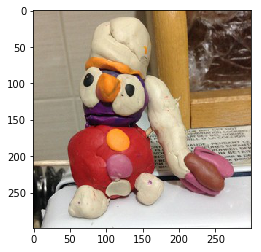

a stuffed bear sitting on a chair with a stuffed animal .
a teddy bear sitting on a chair with a stuffed animal
a stuffed bear is sitting on a chair
a stuffed bear sitting on top of a wooden table .
a stuffed bear is sitting on a table
a stuffed bear is sitting on a chair
a stuffed bear sitting on a chair next to a teddy bear .
a stuffed teddy bear sitting on a chair .
a stuffed animal sitting on a bed with a stuffed animal
a teddy bear in a white dress and a blue bag






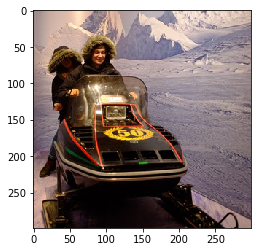

a man sitting on a motorcycle with a dog on it .
a man sitting on a motorcycle next to a motorcycle .
a man sitting on a motorcycle with a dog on his head .
a man sitting on a motorcycle with a dog on it .
a man sitting on a motorcycle in the snow .
a man riding a motorcycle with a dog in the back .
a man sitting on a motorcycle with a dog .
a man on a motorcycle with a dog in his hand .
a man sitting on a motorcycle with a dog in his hand .
a man sitting on a motorcycle in the middle of a road .






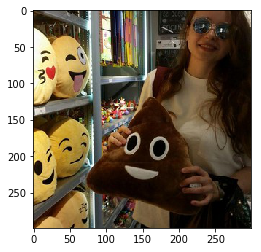

a woman holding a teddy bear in front of a store .
a woman is holding a teddy bear in a store .
a woman is standing in front of a store .
a woman is holding a teddy bear in a store .
a woman is standing next to a teddy bear .
a woman is holding a stuffed bear in a store .
a woman in a black and white photo of a person holding a teddy bear .
a woman holding a teddy bear in front of a store .
a woman holding a teddy bear in front of a store .
a woman is standing next to a teddy bear .






In [80]:
imgs_dir = 'imgs'

for img_name in os.listdir(imgs_dir):
    img = plt.imread(path_join(imgs_dir, img_name))
    img = imresize(img, (299, 299)).astype('float32') / 255.
    
    plt.figure()
    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))
    print('\n\n\n')
    

Видим, что в целом описания адекватны. Есть проблема с описанием пляжа, потому что сеть натренирована выдавать подробные описания картинок, а так как на пляже больше ничего нет, то ей приходится выдумывать что-то лишнее.

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563